In [30]:
!git clone https://github.com/eunicean/Proyecto-DeepLearning.git

fatal: destination path 'Proyecto-DeepLearning' already exists and is not an empty directory.


In [2]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("farukece/handwritten-japanese-hiragana-characters")

print("Path to dataset files:", dataset_path)

100%|██████████| 31.7M/31.7M [00:00<00:00, 62.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farukece/handwritten-japanese-hiragana-characters/versions/1


In [3]:
# Instalar librerías necesarias
!pip install lime scikit-image -q

print("Dependencias instaladas correctamente")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Dependencias instaladas correctamente


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import os

print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU disponible: []


In [5]:
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    # Solo mostrar los primeros niveles para no saturar
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Mostrar solo los primeros 5 archivos
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... y {len(files) - 5} archivos más')

    if level >= 3:
        break

1/
  hiragana/
    shi/
    mi/
    ri/
    ki/
    wo/
    nu/
    no/
    ha/
    yu/
    he/
    uu/
    ko/
    fu/
    ru/
    nn/
    ku/
    se/
    ee/
    yo/
    te/
    ni/
    ra/
    so/
    ma/
    ii/
    tsu/
    ne/
    na/
    wa/
    ka/
    ta/
    ya/
    re/
    me/
    mo/
    aa/
    sa/
    su/
    ke/
    to/
    ro/
    oo/
    chi/
    mu/
    ho/
    hi/


In [6]:
# Analizar cada carpeta de hiragana
hiragana_path = os.path.join(dataset_path, "hiragana")

# Diccionario para almacenar la información
hiragana_data = {}

print("Conteo de imágenes por carácter Hiragana:")

for character_folder in sorted(os.listdir(hiragana_path)):
    folder_path = os.path.join(hiragana_path, character_folder)

    if os.path.isdir(folder_path):
        # Contar archivos de imagen
        image_files = [f for f in os.listdir(folder_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        hiragana_data[character_folder] = {
            'num_imagenes': len(image_files),
            'ruta': folder_path,
            'archivos': image_files
        }

        print(f"{character_folder:8s} tiene {len(image_files):3d} imágenes")

# Crear DataFrame para análisis
df_hiragana = pd.DataFrame.from_dict(hiragana_data, orient='index')
df_hiragana = df_hiragana.reset_index().rename(columns={'index': 'caracter'})

print("\n")
print(f"RESUMEN:")
print(f"Total de caracteres: {len(df_hiragana)}")
print(f"Total de imágenes: {df_hiragana['num_imagenes'].sum()}")
print(f"\nEstadísticas:")
print(f"  - Mínimo: {df_hiragana['num_imagenes'].min()} imágenes")
print(f"  - Máximo: {df_hiragana['num_imagenes'].max()} imágenes")
print(f"  - Promedio: {df_hiragana['num_imagenes'].mean():.2f} imágenes")
print(f"  - Mediana: {df_hiragana['num_imagenes'].median():.0f} imágenes")

# Verificar si todas las clases tienen 100 imágenes
clases_con_100 = df_hiragana[df_hiragana['num_imagenes'] == 100]
print(f"\nClases con exactamente 100 imágenes: {len(clases_con_100)}/{len(df_hiragana)}")

if len(df_hiragana) != len(clases_con_100):
    print("\nClases con cantidad diferente a 100:")
    clases_diferentes = df_hiragana[df_hiragana['num_imagenes'] != 100]
    for _, row in clases_diferentes.iterrows():
        print(f"  - {row['caracter']}: {row['num_imagenes']} imágenes")

Conteo de imágenes por carácter Hiragana:
aa       tiene 100 imágenes
chi      tiene 100 imágenes
ee       tiene 100 imágenes
fu       tiene 100 imágenes
ha       tiene 100 imágenes
he       tiene 100 imágenes
hi       tiene 100 imágenes
ho       tiene 100 imágenes
ii       tiene 100 imágenes
ka       tiene 100 imágenes
ke       tiene 100 imágenes
ki       tiene 100 imágenes
ko       tiene 100 imágenes
ku       tiene 100 imágenes
ma       tiene 100 imágenes
me       tiene 100 imágenes
mi       tiene 100 imágenes
mo       tiene 100 imágenes
mu       tiene 100 imágenes
na       tiene 100 imágenes
ne       tiene 100 imágenes
ni       tiene 100 imágenes
nn       tiene 100 imágenes
no       tiene 100 imágenes
nu       tiene 100 imágenes
oo       tiene 100 imágenes
ra       tiene 100 imágenes
re       tiene 100 imágenes
ri       tiene 100 imágenes
ro       tiene 100 imágenes
ru       tiene 100 imágenes
sa       tiene 100 imágenes
se       tiene 100 imágenes
shi      tiene 100 imágenes
so    

# División en entrenamiento y prueba

In [7]:
from sklearn.model_selection import train_test_split
import shutil

# Configuración de la división
TRAIN_RATIO = 0.70  # 70% entrenamiento
VAL_RATIO = 0.15    # 15% validación
TEST_RATIO = 0.15   # 15% test

print(" Configuración de división del dataset:")
print("\n")
print(f"Train: {TRAIN_RATIO*100:.0f}% ({int(100*TRAIN_RATIO)} imágenes por clase)")
print(f"Validation: {VAL_RATIO*100:.0f}% ({int(100*VAL_RATIO)} imágenes por clase)")
print(f"Test: {TEST_RATIO*100:.0f}% ({int(100*TEST_RATIO)} imágenes por clase)")
print(f"\nTotal por clase: 100 imágenes")
print("\n")

# Crear estructura de directorios
base_output_path = "/content/hiragana_dataset"
splits = ['train', 'val', 'test']

# Crear carpetas
for split in splits:
    split_path = os.path.join(base_output_path, split)
    os.makedirs(split_path, exist_ok=True)
    print(f" Creado: {split_path}")

print("\nProcesando división del dataset...")

# Realizar la división estratificada para cada clase
np.random.seed(42)  # Para reproducibilidad

stats = {
    'train': 0,
    'val': 0,
    'test': 0
}

for character in sorted(df_hiragana['caracter']):
    # Obtener la ruta de la carpeta del carácter
    source_folder = os.path.join(hiragana_path, character)

    # Obtener lista de imágenes
    images = [f for f in os.listdir(source_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Mezclar aleatoriamente
    np.random.shuffle(images)

    # Calcular índices de división
    n_images = len(images)
    train_end = int(n_images * TRAIN_RATIO)
    val_end = train_end + int(n_images * VAL_RATIO)

    # Dividir las imágenes
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Crear carpetas para cada split
    for split in splits:
        split_char_path = os.path.join(base_output_path, split, character)
        os.makedirs(split_char_path, exist_ok=True)

    # Copiar imágenes a sus respectivas carpetas
    # TRAIN
    for img in train_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'train', character, img)
        shutil.copy2(src, dst)
        stats['train'] += 1

    # VALIDATION
    for img in val_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'val', character, img)
        shutil.copy2(src, dst)
        stats['val'] += 1

    # TEST
    for img in test_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'test', character, img)
        shutil.copy2(src, dst)
        stats['test'] += 1

print("\nResumen de la división:")
print("\n")
print(f"Train:      {stats['train']:4d} imágenes ({stats['train']/4600*100:.1f}%)")
print(f"Validation: {stats['val']:4d} imágenes ({stats['val']/4600*100:.1f}%)")
print(f"Test:       {stats['test']:4d} imágenes ({stats['test']/4600*100:.1f}%)")
print(f"Total:      {sum(stats.values()):4d} imágenes")
print("\n")

 Configuración de división del dataset:


Train: 70% (70 imágenes por clase)
Validation: 15% (15 imágenes por clase)
Test: 15% (15 imágenes por clase)

Total por clase: 100 imágenes


 Creado: /content/hiragana_dataset/train
 Creado: /content/hiragana_dataset/val
 Creado: /content/hiragana_dataset/test

Procesando división del dataset...

Resumen de la división:


Train:      3220 imágenes (70.0%)
Validation:  690 imágenes (15.0%)
Test:        690 imágenes (15.0%)
Total:      4600 imágenes




# Configuración

In [8]:
# Configuración de hiperparámetros
IMG_HEIGHT = 128  # MobileNetV2 funciona mejor con imágenes más grandes
IMG_WIDTH = 128
IMG_CHANNELS = 3  # RGB para transfer learning

BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001  # LR más bajo para fine-tuning
NUM_CLASSES = 46

# Rutas del dataset
base_output_path = "/content/hiragana_dataset"

# Clases en orden alfabético
class_labels = ['aa', 'chi', 'ee', 'fu', 'ha', 'he', 'hi', 'ho', 'ii',
                'ka', 'ke', 'ki', 'ko', 'ku', 'ma', 'me', 'mi', 'mo',
                'mu', 'na', 'ne', 'ni', 'nn', 'no', 'nu', 'oo', 'ra',
                're', 'ri', 'ro', 'ru', 'sa', 'se', 'shi', 'so', 'su',
                'ta', 'te', 'tsu', 'to', 'uu', 'wa', 'wo', 'ya', 'yo', 'yu']

print(f"Configuración:")
print(f"  Tamaño de imagen: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Número de clases: {NUM_CLASSES}")

Configuración:
  Tamaño de imagen: 128x128x3
  Batch size: 32
  Epochs: 20
  Learning rate: 0.0001
  Número de clases: 46


In [9]:
# Generadores de datos (ahora RGB)
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Cargar datos
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_output_path, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',  # Cambio importante: RGB
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_output_path, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_output_path, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42
)

print(f"\nDatos cargados:")
print(f"  Train: {train_generator.samples} imágenes")
print(f"  Validation: {val_generator.samples} imágenes")
print(f"  Test: {test_generator.samples} imágenes")

# Guardar mapeo de clases
class_indices = train_generator.class_indices
print(f"\nClases detectadas: {len(class_indices)}")

Found 3220 images belonging to 46 classes.
Found 690 images belonging to 46 classes.
Found 690 images belonging to 46 classes.

Datos cargados:
  Train: 3220 imágenes
  Validation: 690 imágenes
  Test: 690 imágenes

Clases detectadas: 46


In [10]:
print("CONSTRUCCIÓN DEL MODELO CON TRANSFER LEARNING")
print("=" * 60)

# Cargar MobileNetV2 preentrenado (sin la capa superior)
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet'
)

print(f"Modelo base: MobileNetV2")
print(f"  Parámetros totales: {base_model.count_params():,}")

# Congelar las capas del modelo base
base_model.trainable = False
print(f"  Capas congeladas: {len(base_model.layers)}")

# Construir el modelo completo
model = models.Sequential(name='Hiragana_Transfer_Learning')

# Modelo base
model.add(base_model)

# Global Average Pooling
model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))

# Capas densas personalizadas
model.add(layers.Dense(256, activation='relu', name='dense1'))
model.add(layers.Dropout(0.5, name='dropout1'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='output'))

print("\nArquitectura del modelo:")
model.summary()

print(f"\nTotal de parámetros: {model.count_params():,}")
print(f"Parámetros entrenables: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Parámetros no entrenables: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

CONSTRUCCIÓN DEL MODELO CON TRANSFER LEARNING
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo base: MobileNetV2
  Parámetros totales: 2,257,984
  Capas congeladas: 154

Arquitectura del modelo:


Model: "Hiragana_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │        11,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,742 (9.91 MB)

 Trainable params: 339,758 (1.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Total de parámetros: 2,597,742
Parámetros entrenables: 339,758
Parámetros no entrenables: 2,257,984


In [11]:
print("\nCOMPILACIÓN DEL MODELO")
print("=" * 60)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Optimizador: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print("Función de pérdida: Categorical Crossentropy")
print("Métrica: Accuracy")
print("\nModelo compilado correctamente")


COMPILACIÓN DEL MODELO
Optimizador: Adam
  Learning rate: 0.0001
Función de pérdida: Categorical Crossentropy
Métrica: Accuracy

Modelo compilado correctamente


In [12]:
print("\nCONFIGURACIÓN DE CALLBACKS")
print("=" * 60)

# ModelCheckpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='/content/best_hiragana_transfer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
print("ModelCheckpoint: Guardará el mejor modelo")

# EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
print("EarlyStopping: Paciencia de 5 epochs")

# ReduceLROnPlateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
print("ReduceLROnPlateau: Reduce LR si se estanca")

callbacks_list = [checkpoint, early_stopping, reduce_lr]
print("\nCallbacks configurados")


CONFIGURACIÓN DE CALLBACKS
ModelCheckpoint: Guardará el mejor modelo
EarlyStopping: Paciencia de 5 epochs
ReduceLROnPlateau: Reduce LR si se estanca

Callbacks configurados


In [13]:
print("\nINICIANDO ENTRENAMIENTO")
print("=" * 60)
print(f"Epochs máximos: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("=" * 60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "=" * 60)
print("ENTRENAMIENTO COMPLETADO")
print("=" * 60)


INICIANDO ENTRENAMIENTO
Epochs máximos: 20
Batch size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.1040 - loss: 3.8958
Epoch 1: val_accuracy improved from -inf to 0.85652, saving model to /content/best_hiragana_transfer_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 85s 680ms/step - accuracy: 0.1051 - loss: 3.8897 - val_accuracy: 0.8565 - val_loss: 1.9142 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6154 - loss: 1.8584
Epoch 2: val_accuracy improved from 0.85652 to 0.97826, saving model to /content/best_hiragana_transfer_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 63s 624ms/step - accuracy: 0.6161 - loss: 1.8556 - val_accuracy: 0.9783 - val_loss: 0.7080 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8434 - loss: 0.8991
Epoch 3: val_accuracy improved from 0.97826 to 1.00000, saving model to /content/best_hiragana_transfer_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 531ms/step - accuracy: 0.8438 - loss: 0.8979 - val_accuracy: 1.0000 - val_loss: 0.2910 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9373 - loss: 0.4805
Epoch 4: val_accuracy did not improve from 1.00000
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 544ms/step - accuracy: 0.9374 - loss: 0.4799 - val_accuracy: 1.0000 - val_loss: 0.1461 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9551 - loss: 0.3305
Epoch 5: val_accuracy did not improve from 1.00000
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - accuracy: 0.9551 - loss: 0.3302 - val_accuracy: 1.0000 - val_loss: 0.0919 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9725 - loss: 0.2293
Epoch 6: val_accuracy did not improve from 1.00000
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 544ms/step - accuracy: 0.9725 - loss: 0.2291 - val_accuracy: 1.0000 - val_loss: 0.0586 - learning_rate: 1.


VISUALIZACIÓN DE CURVAS DE APRENDIZAJE


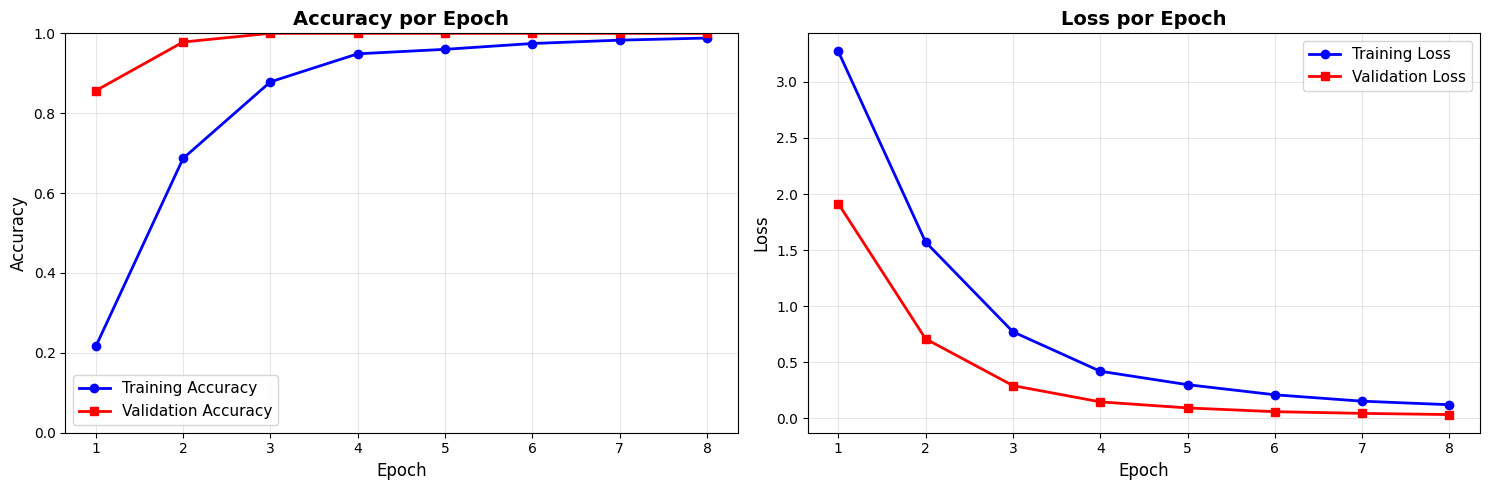


RESULTADOS DEL ENTRENAMIENTO:
Epochs completados: 8

Mejor validation accuracy: 1.0000 (Epoch 3)
Training accuracy final: 0.9882
Validation accuracy final: 1.0000

Mejor validation loss: 0.0327 (Epoch 8)
Training loss final: 0.1206
Validation loss final: 0.0327

Gap entre train y validation: -0.0118
  Buen balance entre train y validation


In [14]:
print("\nVISUALIZACIÓN DE CURVAS DE APRENDIZAJE")
print("=" * 60)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy
axes[0].plot(epochs_range, train_accuracy, 'b-o', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_accuracy, 'r-s', label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy por Epoch', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Gráfico 2: Loss
axes[1].plot(epochs_range, train_loss, 'b-o', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-s', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss por Epoch', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/transfer_learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nRESULTADOS DEL ENTRENAMIENTO:")
print("=" * 60)
print(f"Epochs completados: {len(train_loss)}")
print(f"\nMejor validation accuracy: {max(val_accuracy):.4f} (Epoch {val_accuracy.index(max(val_accuracy)) + 1})")
print(f"Training accuracy final: {train_accuracy[-1]:.4f}")
print(f"Validation accuracy final: {val_accuracy[-1]:.4f}")
print(f"\nMejor validation loss: {min(val_loss):.4f} (Epoch {val_loss.index(min(val_loss)) + 1})")
print(f"Training loss final: {train_loss[-1]:.4f}")
print(f"Validation loss final: {val_loss[-1]:.4f}")

gap = train_accuracy[-1] - val_accuracy[-1]
print(f"\nGap entre train y validation: {gap:.4f}")
if gap > 0.1:
    print("  Posible overfitting detectado")
elif gap < 0.05:
    print("  Buen balance entre train y validation")
else:
    print("  Gap aceptable")

In [15]:
print("\nEVALUACIÓN EN EL TEST SET")
print("=" * 60)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\nRESULTADOS FINALES:")
print("=" * 60)
print(f"Training Accuracy:   {train_accuracy[-1]:.4f} ({train_accuracy[-1]*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f} ({val_accuracy[-1]*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 60)
print(f"Training Loss:       {train_loss[-1]:.4f}")
print(f"Validation Loss:     {val_loss[-1]:.4f}")
print(f"Test Loss:           {test_loss:.4f}")
print("=" * 60)

if test_accuracy >= 0.95:
    print("\nEXCELENTE: El modelo generaliza muy bien (>95%)")
elif test_accuracy >= 0.90:
    print("\nBUENO: El modelo generaliza bien (90-95%)")
elif test_accuracy >= 0.85:
    print("\nACEPTABLE: El modelo generaliza razonablemente (85-90%)")
else:
    print("\nATENCIÓN: Posible overfitting (test accuracy < 85%)")

gap_test = val_accuracy[-1] - test_accuracy
print(f"\nDiferencia val-test: {gap_test:.4f}")
if abs(gap_test) < 0.05:
    print("Generalización consistente entre validación y test")


EVALUACIÓN EN EL TEST SET
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - accuracy: 0.9977 - loss: 0.3657

RESULTADOS FINALES:
Training Accuracy:   0.9882 (98.82%)
Validation Accuracy: 1.0000 (100.00%)
Test Accuracy:       0.9971 (99.71%)
Training Loss:       0.1206
Validation Loss:     0.0327
Test Loss:           0.3004

EXCELENTE: El modelo generaliza muy bien (>95%)

Diferencia val-test: 0.0029
Generalización consistente entre validación y test


In [16]:
print("\nGENERANDO PREDICCIONES PARA ANÁLISIS")
print("=" * 60)

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print(f"\nPredicciones generadas: {len(predicted_classes)}")
print(f"Clases únicas: {len(class_labels)}")


GENERANDO PREDICCIONES PARA ANÁLISIS
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step

Predicciones generadas: 690
Clases únicas: 46



MATRIZ DE CONFUSIÓN
Matriz generada: (46, 46)
Total de predicciones: 690
Predicciones correctas: 688
Predicciones incorrectas: 2


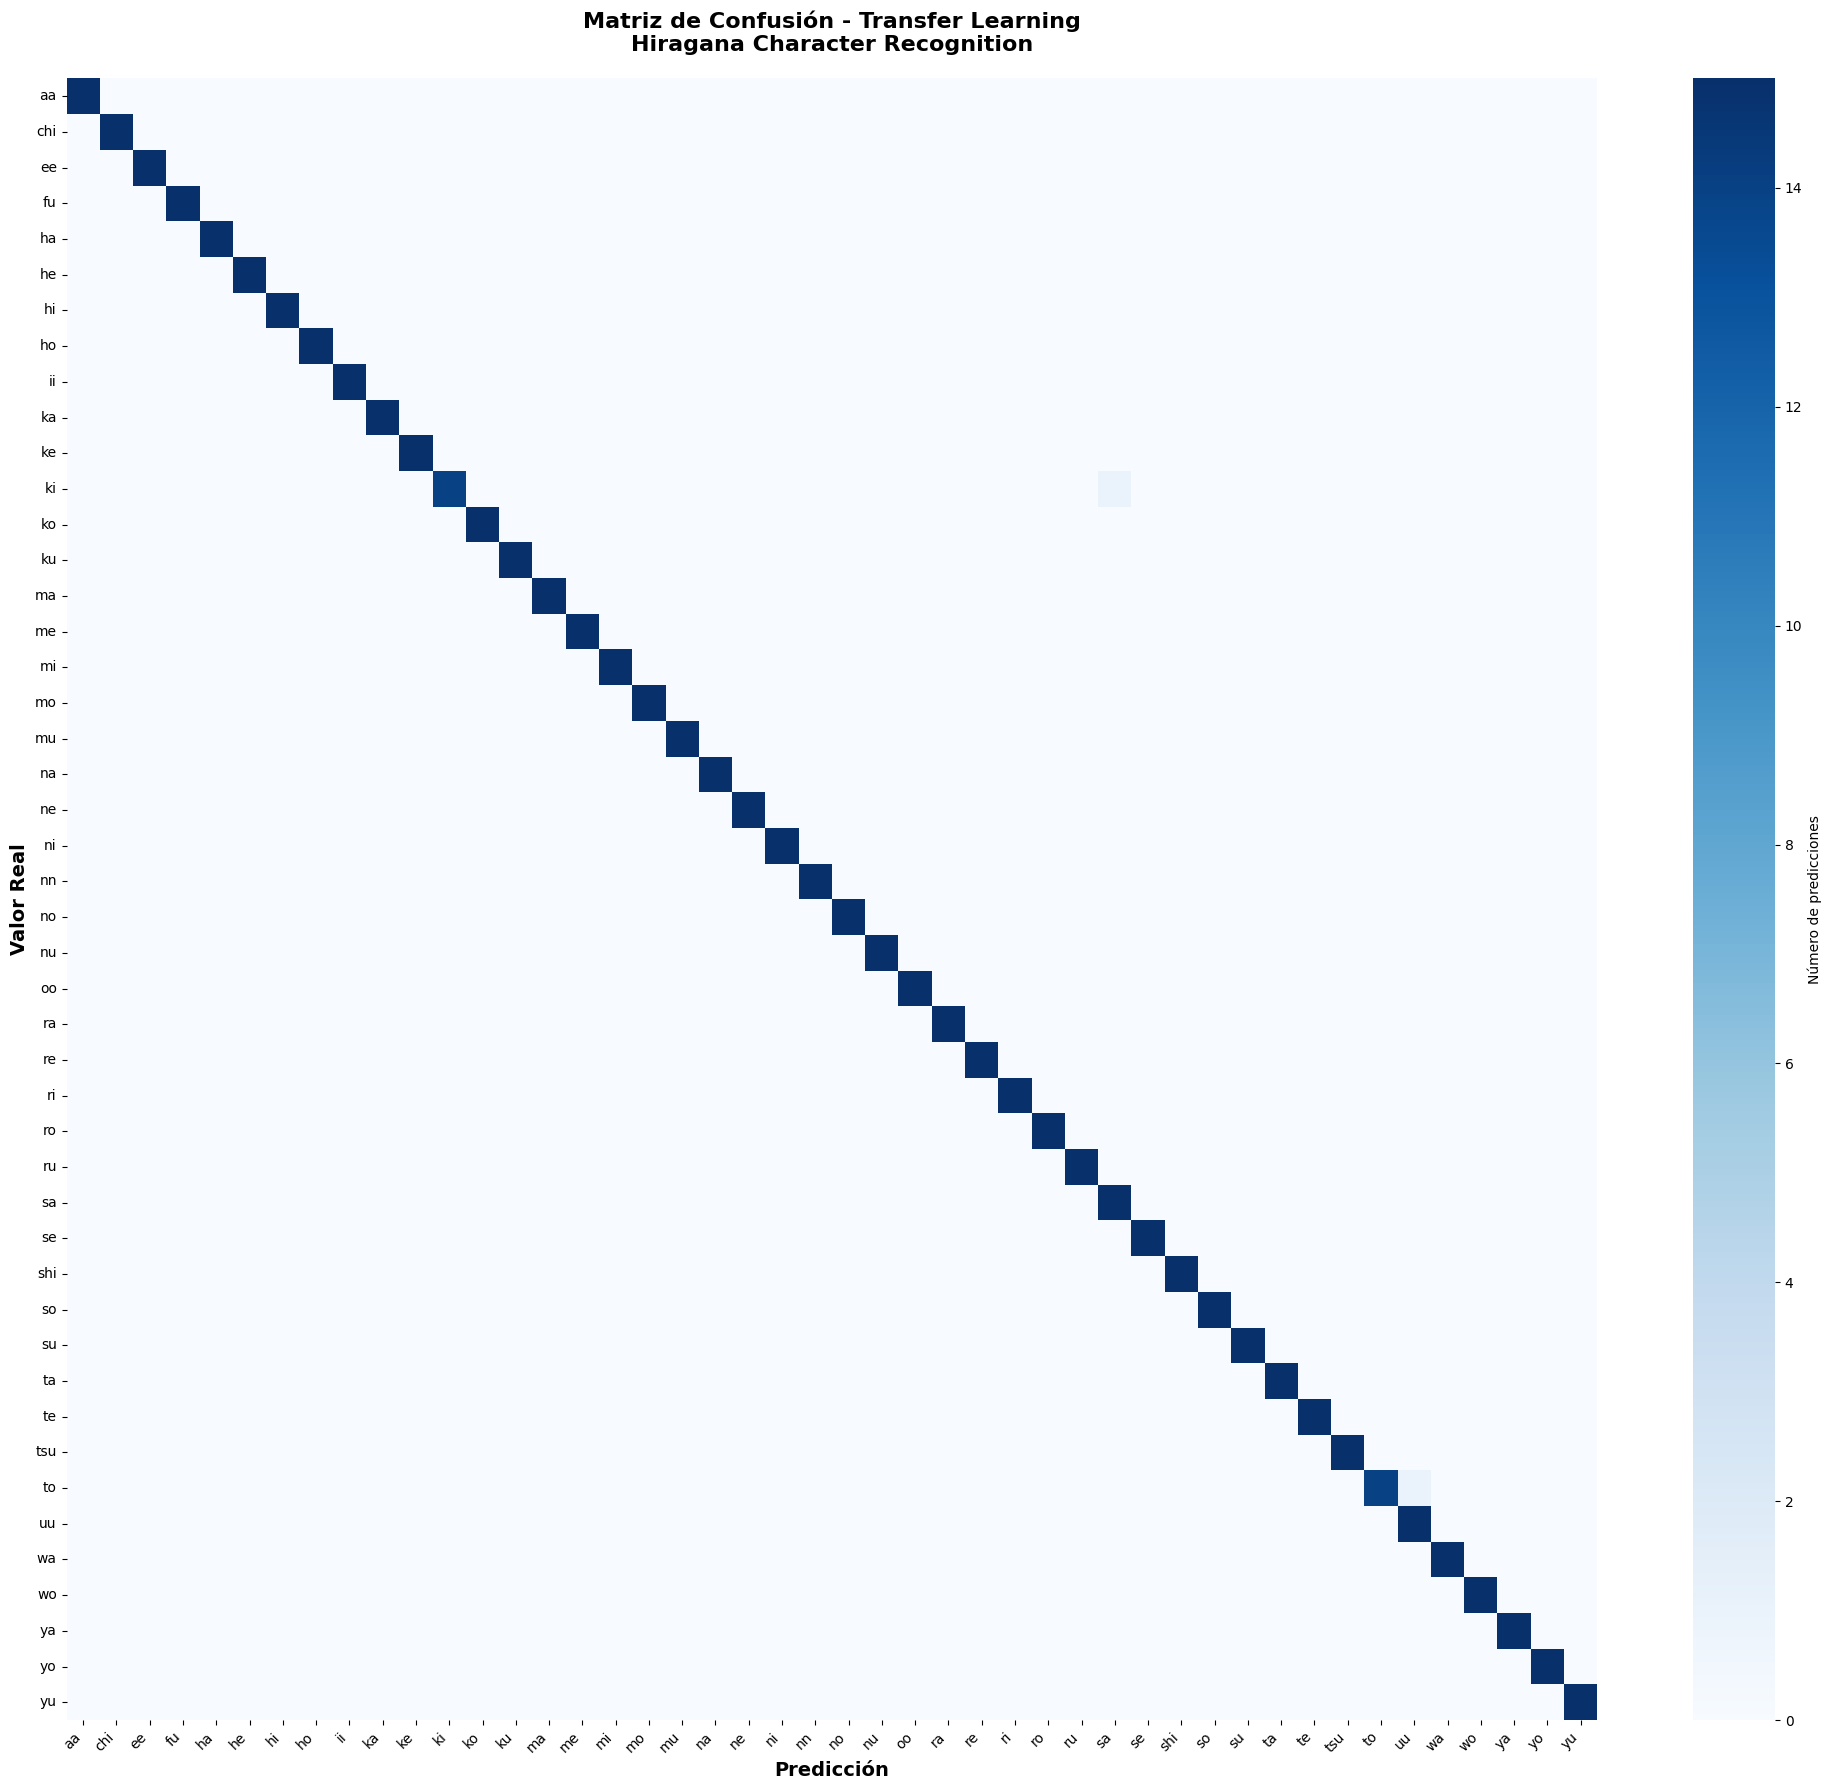


Diagonal = predicciones correctas
Fuera de diagonal = confusiones entre clases


In [17]:
print("\nMATRIZ DE CONFUSIÓN")
print("=" * 60)

cm = confusion_matrix(true_classes, predicted_classes)

print(f"Matriz generada: {cm.shape}")
print(f"Total de predicciones: {cm.sum()}")
print(f"Predicciones correctas: {np.trace(cm)}")
print(f"Predicciones incorrectas: {cm.sum() - np.trace(cm)}")

# Visualizar matriz de confusión
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Número de predicciones'})
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.title('Matriz de Confusión - Transfer Learning\nHiragana Character Recognition',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/confusion_matrix_transfer.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDiagonal = predicciones correctas")
print("Fuera de diagonal = confusiones entre clases")

In [18]:
print("\nREPORTE DE CLASIFICACIÓN")
print("=" * 60)

report = classification_report(true_classes, predicted_classes,
                              target_names=class_labels,
                              digits=4)
print(report)


REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

          aa     1.0000    1.0000    1.0000        15
         chi     1.0000    1.0000    1.0000        15
          ee     1.0000    1.0000    1.0000        15
          fu     1.0000    1.0000    1.0000        15
          ha     1.0000    1.0000    1.0000        15
          he     1.0000    1.0000    1.0000        15
          hi     1.0000    1.0000    1.0000        15
          ho     1.0000    1.0000    1.0000        15
          ii     1.0000    1.0000    1.0000        15
          ka     1.0000    1.0000    1.0000        15
          ke     1.0000    1.0000    1.0000        15
          ki     1.0000    0.9333    0.9655        15
          ko     1.0000    1.0000    1.0000        15
          ku     1.0000    1.0000    1.0000        15
          ma     1.0000    1.0000    1.0000        15
          me     1.0000    1.0000    1.0000        15
          mi     1.0000    1.0000    1.0000        15
 

In [19]:
def predict_hiragana_image(image_path, model, class_labels, top_n=5):
    """
    Predice el carácter hiragana de una imagen usando el modelo de transfer learning

    Args:
        image_path: Ruta a la imagen
        model: Modelo entrenado
        class_labels: Lista de nombres de clases
        top_n: Número de predicciones top a mostrar

    Returns:
        dict con predicted_class, confidence y top_predictions
    """

    print(f"\nPREDICCIÓN CON TRANSFER LEARNING")
    print("=" * 60)
    print(f"Imagen: {os.path.basename(image_path)}")

    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen")
        return None

    # Cargar y preprocesar imagen
    img = Image.open(image_path)

    # Convertir a RGB (importante para transfer learning)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Redimensionar
    img_resized = img.resize((IMG_HEIGHT, IMG_WIDTH))

    # Convertir a array y normalizar
    img_array = np.array(img_resized) / 255.0
    img_input = img_array.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

    # Predecir
    prediction = model.predict(img_input, verbose=0)

    # Extraer resultados
    predicted_idx = np.argmax(prediction[0])
    predicted_class = class_labels[predicted_idx]
    confidence = prediction[0][predicted_idx] * 100

    # Top N
    top_indices = np.argsort(prediction[0])[-top_n:][::-1]
    top_predictions = [(class_labels[idx], prediction[0][idx]*100)
                       for idx in top_indices]

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Imagen original
    axes[0].imshow(img)
    axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Gráfico de barras con top predicciones
    classes = [item[0] for item in top_predictions]
    probs = [item[1] for item in top_predictions]

    colors = ['green' if i == 0 else 'steelblue' for i in range(len(classes))]
    bars = axes[1].barh(range(len(classes)), probs, color=colors, edgecolor='black')
    axes[1].set_yticks(range(len(classes)))
    axes[1].set_yticklabels(classes)
    axes[1].set_xlabel('Probabilidad (%)', fontsize=11)
    axes[1].set_title(f'Top {top_n} Predicciones', fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].set_xlim([0, 100])

    for i, (bar, prob) in enumerate(zip(bars, probs)):
        axes[1].text(prob + 2, i, f'{prob:.1f}%',
                    va='center', fontsize=9, fontweight='bold')

    plt.suptitle(f'Predicción: {predicted_class} ({confidence:.1f}%)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Resultados en texto
    print(f"\nPREDICCIÓN: {predicted_class}")
    print(f"CONFIANZA: {confidence:.2f}%")
    print(f"\nTop {top_n}:")
    for i, (class_name, prob) in enumerate(top_predictions, 1):
        bar = "█" * int(prob/2)
        print(f"  {i}. {class_name:5s} : {prob:6.2f}% {bar}")

    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'top_predictions': top_predictions,
        'image_path': image_path
    }

print("Función predict_hiragana_image creada")

Función predict_hiragana_image creada



PREDICCIÓN CON TRANSFER LEARNING
Imagen: ni_testL.jpeg


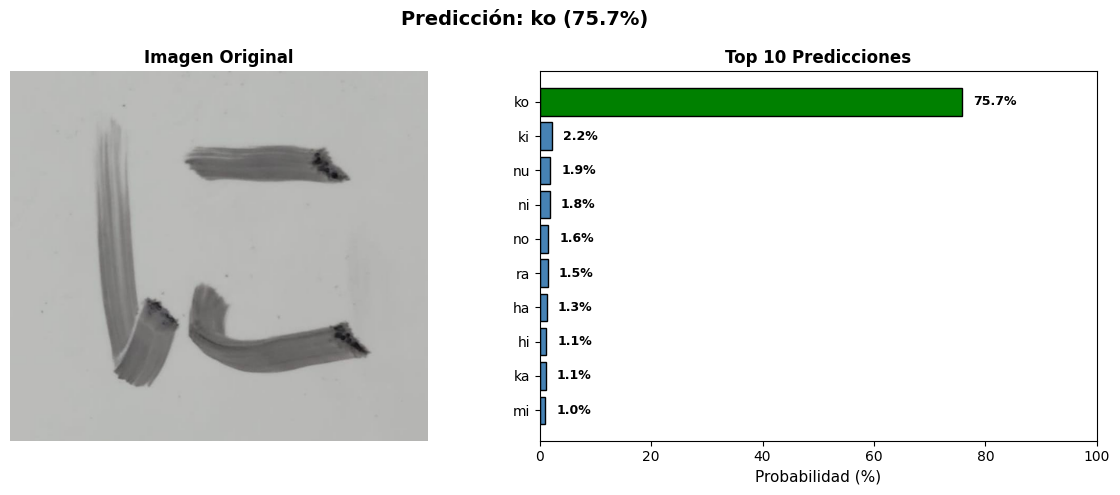


PREDICCIÓN: ko
CONFIANZA: 75.75%

Top 10:
  1. ko    :  75.75% █████████████████████████████████████
  2. ki    :   2.19% █
  3. nu    :   1.85% 
  4. ni    :   1.78% 
  5. no    :   1.56% 
  6. ra    :   1.49% 
  7. ha    :   1.26% 
  8. hi    :   1.13% 
  9. ka    :   1.12% 
  10. mi    :   1.04% 


In [20]:
# Probar con la imagen proporcionada
test_image_path = '/content/Proyecto-DeepLearning/extra_imgs/ni_testL.jpeg'

result = predict_hiragana_image(
    test_image_path,
    model,
    class_labels,
    top_n=10
)

In [24]:
print("\nGUARDANDO MODELO")
print("=" * 60)

# Guardar modelo completo
model.save('/content/hiragana_transfer_learning_model.h5')
print("Modelo guardado: hiragana_transfer_learning_model.h5")

# Guardar solo los pesos
model.save_weights('/content/hiragana_transfer.weights.h5')
print("Pesos guardados: hiragana_transfer.weights.h5")

# Información del modelo
model_size = os.path.getsize('/content/hiragana_transfer_learning_model.h5') / (1024 * 1024)
print(f"\nTamaño del modelo: {model_size:.2f} MB")
print(f"Parámetros totales: {model.count_params():,}")


GUARDANDO MODELO
Modelo guardado: hiragana_transfer_learning_model.h5
Pesos guardados: hiragana_transfer_weights.h5

Tamaño del modelo: 12.86 MB
Parámetros totales: 2,597,742


In [25]:
# Instalar LIME
!pip install lime scikit-image -q

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("LIME instalado correctamente")

LIME instalado correctamente


In [26]:
def predict_proba(images):
    """
    Función de predicción para LIME (Transfer Learning)

    Args:
        images: Array de imágenes RGB (N, H, W, 3)

    Returns:
        Array de probabilidades (N, 46)
    """
    batch_size = images.shape[0]
    processed_images = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    for i in range(batch_size):
        img_rgb = images[i]

        # Normalizar
        img_normalized = img_rgb / 255.0

        processed_images[i] = img_normalized

    # Predecir
    predictions = model.predict(processed_images, verbose=0)

    return predictions

print("Función predict_proba creada para Transfer Learning")

Función predict_proba creada para Transfer Learning


In [27]:
# Crear el explicador LIME
explainer = lime_image.LimeImageExplainer()

print("Explicador LIME creado exitosamente")

Explicador LIME creado exitosamente


In [28]:
def explain_hiragana_with_lime_transfer(image_path, model, class_labels, idx=0):
    """
    Explica la predicción del modelo de Transfer Learning usando LIME

    Args:
        image_path: Ruta a la imagen
        model: Modelo entrenado
        class_labels: Lista de nombres de clases
        idx: Índice de la imagen (para identificación)
    """

    print(f"\nEXPLICABLE AI - TRANSFER LEARNING")
    print(f"Analizando imagen: {os.path.basename(image_path)}")
    print("=" * 60)

    # Cargar imagen
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((IMG_HEIGHT, IMG_WIDTH))
    img_array = np.array(img_resized)

    # Hacer predicción primero
    img_normalized = img_array / 255.0
    img_input = img_normalized.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    prediction = model.predict(img_input, verbose=0)

    predicted_idx = np.argmax(prediction[0])
    predicted_label = class_labels[predicted_idx]
    confidence = prediction[0][predicted_idx] * 100

    print(f"Predicción del modelo: {predicted_label}")
    print(f"Confianza: {confidence:.2f}%\n")

    # Generar explicación con LIME
    print("Generando explicación con LIME...")
    explanation = explainer.explain_instance(
        img_array,
        predict_proba,
        top_labels=3,
        hide_color=0,
        num_samples=1000
    )

    print("Explicación generada\n")

    # Obtener pesos
    local_exp = explanation.local_exp[predicted_idx]
    weights_dict = dict(local_exp)
    num_regions = len(weights_dict)

    # Obtener máscaras
    temp_all, mask_all = explanation.get_image_and_mask(
        predicted_idx,
        positive_only=False,
        num_features=num_regions,
        hide_rest=False
    )

    # Crear máscara de pesos
    segments = explanation.segments
    weight_mask = np.zeros_like(mask_all, dtype=float)

    for region_id, weight in weights_dict.items():
        weight_mask[segments == region_id] = weight

    # Calcular rangos
    all_weights = list(weights_dict.values())

    if len(all_weights) > 0:
        max_abs_weight = max(abs(min(all_weights)), abs(max(all_weights)))
        vmin, vmax = -max_abs_weight, max_abs_weight

        if max_abs_weight < 0.01:
            vmin, vmax = -0.01, 0.01
    else:
        vmin, vmax = -0.1, 0.1

    single_region = (num_regions == 1)

    if single_region:
        print("CASO ESPECIAL: LIME detectó solo 1 región")
        print(f"  Peso único: {all_weights[0]:.4f}\n")
    else:
        print(f"Rango de visualización: [{vmin:.4f}, {vmax:.4f}]")
        print(f"Total de regiones: {num_regions}\n")

    # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Imagen original
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title(f'Original\nPredicción: {predicted_label} ({confidence:.1f}%)',
                         fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Heatmap de pesos
    if single_region:
        weight_value = all_weights[0]
        colored_mask = np.ones_like(weight_mask)

        if weight_value > 0:
            axes[0, 1].imshow(colored_mask, cmap='Reds', vmin=0, vmax=1)
            title_text = f'Región Única: POSITIVA\nPeso: {weight_value:.4f}'
        else:
            axes[0, 1].imshow(colored_mask, cmap='Blues', vmin=0, vmax=1)
            title_text = f'Región Única: NEGATIVA\nPeso: {weight_value:.4f}'

        axes[0, 1].set_title(title_text, fontsize=11, fontweight='bold')
    else:
        im = axes[0, 1].imshow(weight_mask, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[0, 1].set_title('Mapa de Importancia\n(Rojo=Apoya, Azul=Contradice)',
                             fontsize=11, fontweight='bold')
        plt.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)

    axes[0, 1].axis('off')

    # 3. Segmentación
    # Convertir a escala de grises para mark_boundaries
    img_gray_for_boundary = np.mean(img_array, axis=2) / 255.0
    overlay = mark_boundaries(img_gray_for_boundary, mask_all, color=(0, 1, 0), mode='thick')
    overlay = np.clip(overlay, 0, 1)
    axes[0, 2].imshow(overlay)
    axes[0, 2].set_title(f'Segmentación: {num_regions} regiones',
                         fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # 4. Regiones positivas
    positive_threshold = max(0.01, max_abs_weight * 0.1)
    positive_mask = np.where(weight_mask > positive_threshold, weight_mask, 0)

    if np.any(positive_mask > 0):
        im4 = axes[1, 0].imshow(positive_mask, cmap='Reds', vmin=0,
                                vmax=max(all_weights) if max(all_weights) > 0 else 0.1)
        if not single_region:
            plt.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)
        axes[1, 0].set_title(f'Regiones Positivas\n({np.sum(positive_mask > 0)} píxeles)',
                             fontsize=12, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'Sin regiones\npositivas',
                       transform=axes[1, 0].transAxes,
                       fontsize=14, ha='center', va='center')
        axes[1, 0].set_title('Regiones Positivas (Ninguna)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    # 5. Regiones negativas
    negative_threshold = max(0.01, max_abs_weight * 0.1)
    negative_mask = np.where(weight_mask < -negative_threshold, np.abs(weight_mask), 0)

    if np.any(negative_mask > 0):
        im5 = axes[1, 1].imshow(negative_mask, cmap='Blues', vmin=0,
                                vmax=abs(min(all_weights)) if min(all_weights) < 0 else 0.1)
        if not single_region:
            plt.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)
        axes[1, 1].set_title(f'Regiones Negativas\n({np.sum(negative_mask > 0)} píxeles)',
                             fontsize=12, fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'Sin regiones\nnegativas',
                       transform=axes[1, 1].transAxes,
                       fontsize=14, ha='center', va='center')
        axes[1, 1].set_title('Regiones Negativas (Ninguna)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    # 6. Overlay
    axes[1, 2].imshow(img_array)

    if not single_region:
        axes[1, 2].imshow(weight_mask, cmap='RdBu_r', alpha=0.5, vmin=vmin, vmax=vmax)

    axes[1, 2].set_title('Overlay: Imagen + Importancia', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f'/content/lime_explanation_transfer_{idx}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Análisis numérico
    print("\nANÁLISIS NUMÉRICO DE REGIONES\n")

    sorted_regions = sorted(local_exp, key=lambda x: abs(x[1]), reverse=True)[:10]

    print(f"{'Region':<10} {'Peso':<12} {'% del Max':<12} {'Interpretación':<30}")
    print("-" * 70)

    for region_id, weight in sorted_regions:
        pct_of_max = (abs(weight) / max_abs_weight * 100) if max_abs_weight > 0 else 0

        if weight > max_abs_weight * 0.1:
            interpretation = "APOYA fuertemente"
        elif weight > 0:
            interpretation = "Apoya ligeramente"
        elif weight > -max_abs_weight * 0.1:
            interpretation = "Neutral"
        else:
            interpretation = "CONTRADICE"

        print(f"{region_id:<8} {weight:>+.4f}      {pct_of_max:>6.1f}%      {interpretation}")

    # Estadísticas
    all_weights_list = [w for _, w in local_exp]
    positive_weights = [w for w in all_weights_list if w > positive_threshold]
    negative_weights = [w for w in all_weights_list if w < -negative_threshold]
    neutral_weights = [w for w in all_weights_list
                      if -positive_threshold <= w <= positive_threshold]

    print(f"\nRESUMEN ESTADÍSTICO")
    print(f"Total de regiones: {len(all_weights_list)}")
    print(f"Regiones positivas: {len(positive_weights)} ({len(positive_weights)/len(all_weights_list)*100:.1f}%)")
    print(f"Regiones negativas: {len(negative_weights)} ({len(negative_weights)/len(all_weights_list)*100:.1f}%)")
    print(f"Regiones neutrales: {len(neutral_weights)} ({len(neutral_weights)/len(all_weights_list)*100:.1f}%)")

    if positive_weights:
        print(f"\nPeso positivo máximo: {max(positive_weights):+.4f}")
        print(f"Peso positivo promedio: {np.mean(positive_weights):+.4f}")

    if negative_weights:
        print(f"Peso negativo mínimo: {min(negative_weights):+.4f}")
        print(f"Peso negativo promedio: {np.mean(negative_weights):+.4f}")

print("Función explain_hiragana_with_lime_transfer creada")

Función explain_hiragana_with_lime_transfer creada



EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: ni_testL.jpeg
Predicción del modelo: ko
Confianza: 75.75%

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.1841, 0.1841]
Total de regiones: 13



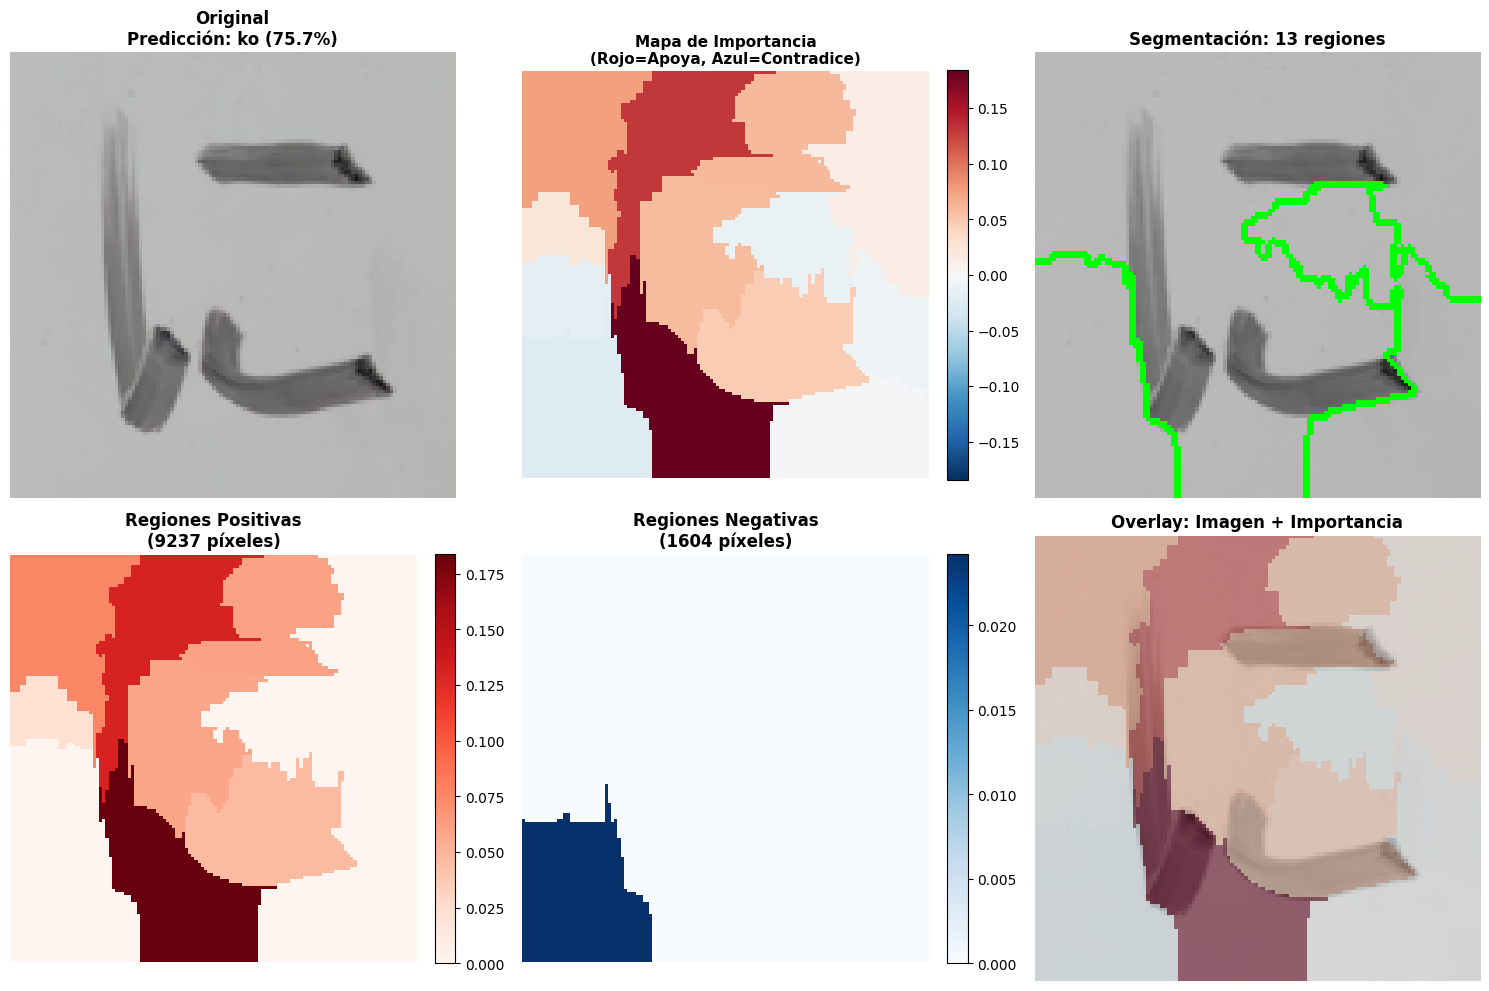


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
12       +0.1841       100.0%      APOYA fuertemente
1        +0.1305        70.9%      APOYA fuertemente
0        +0.0757        41.1%      APOYA fuertemente
2        +0.0598        32.5%      APOYA fuertemente
6        +0.0580        31.5%      APOYA fuertemente
8        +0.0465        25.3%      APOYA fuertemente
10       -0.0243        13.2%      CONTRADICE
4        +0.0222        12.1%      APOYA fuertemente
7        -0.0171         9.3%      Neutral
3        +0.0135         7.3%      Apoya ligeramente

RESUMEN ESTADÍSTICO
Total de regiones: 13
Regiones positivas: 7 (53.8%)
Regiones negativas: 1 (7.7%)
Regiones neutrales: 5 (38.5%)

Peso positivo máximo: +0.1841
Peso positivo promedio: +0.0824
Peso negativo mínimo: -0.0243
Peso negativo promedio: -0.0243


In [38]:
# Explicar la imagen de prueba


explain_hiragana_with_lime_transfer(
    image_path='/content/Proyecto-DeepLearning/extra_imgs/ni_testL.jpeg',
    model=model,
    class_labels=class_labels,
    idx=1
)

Imágenes encontradas en /content/Proyecto-DeepLearning/extra_imgs:
  - ni_test.jpg
  - ko_test.jpg
  - ne_test.jpg
  - ni_test4.jpg
  - ku_test.jpg
  - ta_test.jpg
  - ni_testL.jpeg
  - re_test.jpg

IMAGEN 1/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: ni_test.jpg
Predicción del modelo: ko
Confianza: 12.24%

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0699, 0.0699]
Total de regiones: 13



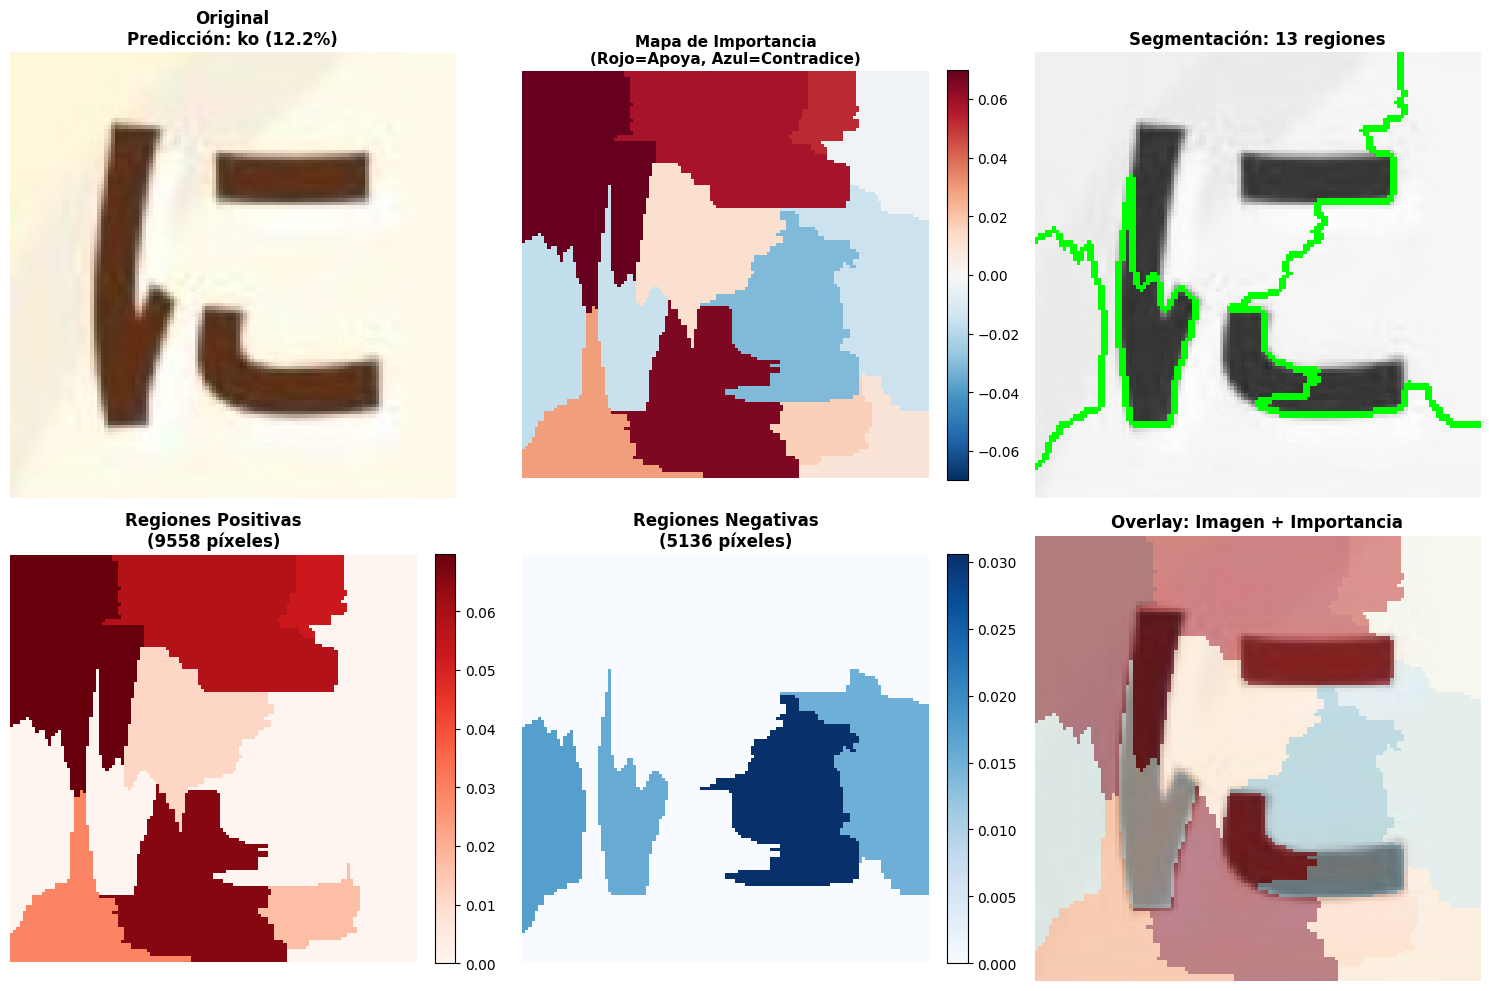


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
0        +0.0699       100.0%      APOYA fuertemente
10       +0.0653        93.4%      APOYA fuertemente
1        +0.0576        82.4%      APOYA fuertemente
3        +0.0522        74.7%      APOYA fuertemente
6        -0.0306        43.8%      CONTRADICE
9        +0.0291        41.7%      APOYA fuertemente
8        -0.0173        24.7%      CONTRADICE
11       +0.0168        24.1%      APOYA fuertemente
7        -0.0156        22.3%      CONTRADICE
5        -0.0152        21.7%      CONTRADICE

RESUMEN ESTADÍSTICO
Total de regiones: 13
Regiones positivas: 7 (53.8%)
Regiones negativas: 4 (30.8%)
Regiones neutrales: 2 (15.4%)

Peso positivo máximo: +0.0699
Peso positivo promedio: +0.0431
Peso negativo mínimo: -0.0306
Peso negativo promedio: -0.0197



IMAGEN 2/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: k

  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0991, 0.0991]
Total de regiones: 13



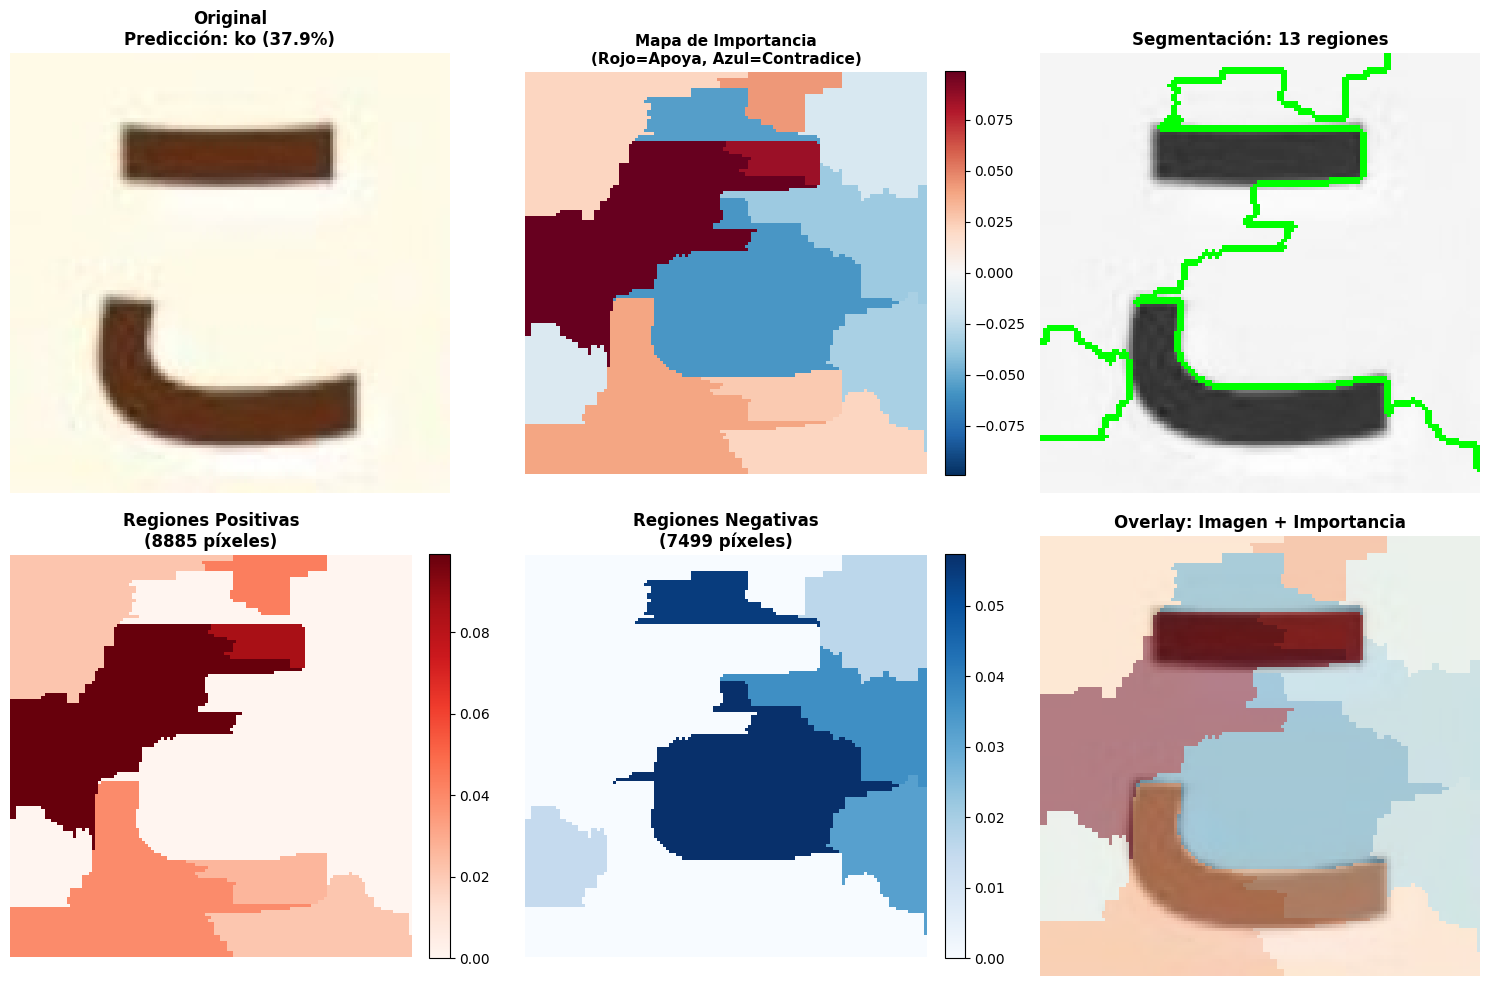


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
6        +0.0991       100.0%      APOYA fuertemente
4        +0.0848        85.6%      APOYA fuertemente
7        -0.0574        57.9%      CONTRADICE
0        -0.0545        55.0%      CONTRADICE
1        +0.0432        43.6%      APOYA fuertemente
11       +0.0395        39.8%      APOYA fuertemente
5        -0.0364        36.7%      CONTRADICE
8        -0.0321        32.4%      CONTRADICE
10       +0.0261        26.3%      APOYA fuertemente
2        +0.0216        21.8%      APOYA fuertemente

RESUMEN ESTADÍSTICO
Total de regiones: 13
Regiones positivas: 7 (53.8%)
Regiones negativas: 6 (46.2%)
Regiones neutrales: 0 (0.0%)

Peso positivo máximo: +0.0991
Peso positivo promedio: +0.0479
Peso negativo mínimo: -0.0574
Peso negativo promedio: -0.0351



IMAGEN 3/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: ne

  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0100, 0.0100]
Total de regiones: 14



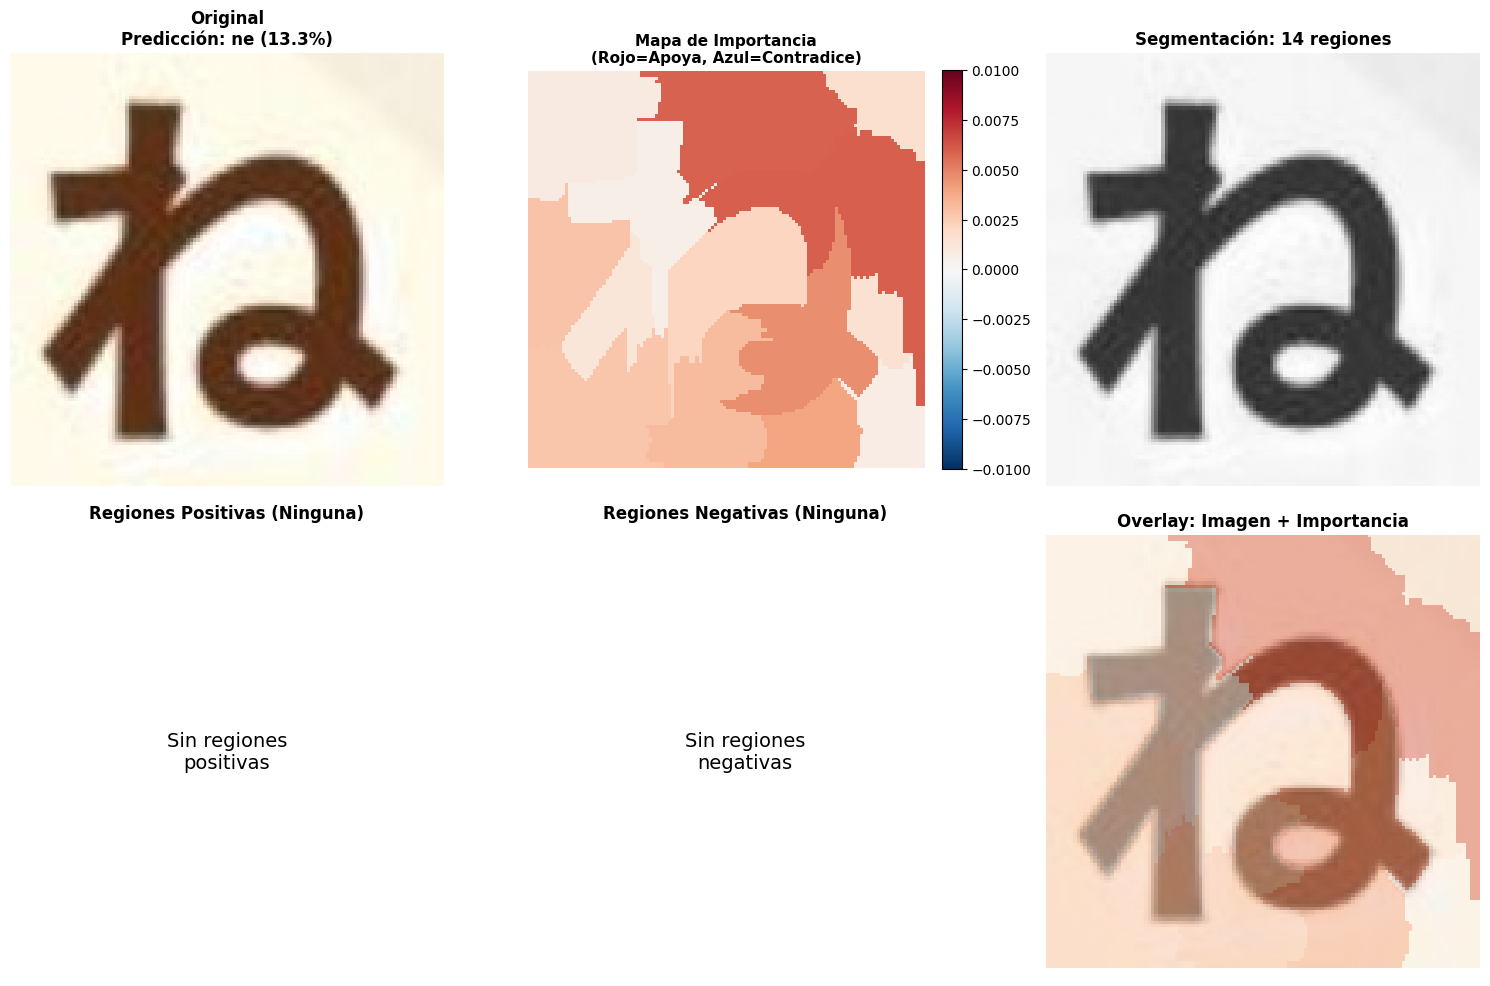


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
3        +0.0060       100.0%      APOYA fuertemente
1        +0.0059        97.8%      APOYA fuertemente
9        +0.0046        77.1%      APOYA fuertemente
13       +0.0039        65.5%      APOYA fuertemente
12       +0.0032        52.8%      APOYA fuertemente
5        +0.0029        47.5%      APOYA fuertemente
10       +0.0028        46.1%      APOYA fuertemente
6        +0.0022        36.3%      APOYA fuertemente
2        +0.0016        26.5%      APOYA fuertemente
8        +0.0016        25.9%      APOYA fuertemente

RESUMEN ESTADÍSTICO
Total de regiones: 14
Regiones positivas: 0 (0.0%)
Regiones negativas: 0 (0.0%)
Regiones neutrales: 14 (100.0%)



IMAGEN 4/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: ni_test4.jpg
Predicción del modelo: ni
Confianza: 30.05%

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0365, 0.0365]
Total de regiones: 15



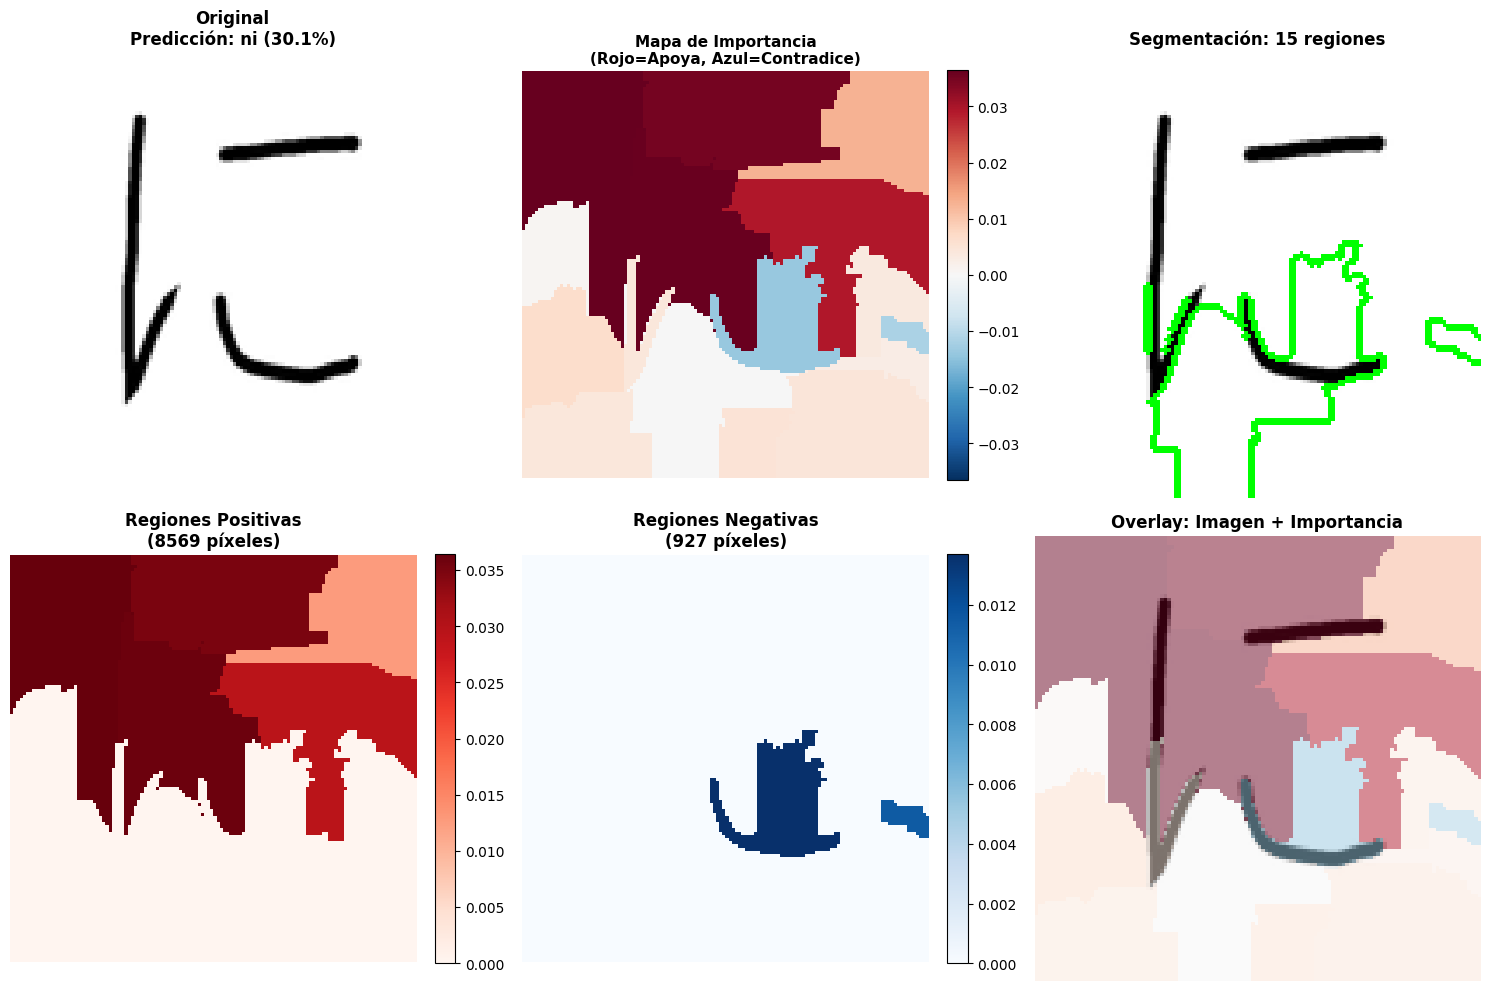


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
1        +0.0365       100.0%      APOYA fuertemente
3        +0.0360        98.7%      APOYA fuertemente
0        +0.0349        95.8%      APOYA fuertemente
5        +0.0292        80.1%      APOYA fuertemente
7        -0.0137        37.6%      CONTRADICE
2        +0.0127        34.8%      APOYA fuertemente
9        -0.0114        31.3%      CONTRADICE
8        +0.0065        17.8%      APOYA fuertemente
14       +0.0050        13.6%      APOYA fuertemente
11       +0.0043        11.7%      APOYA fuertemente

RESUMEN ESTADÍSTICO
Total de regiones: 15
Regiones positivas: 5 (33.3%)
Regiones negativas: 2 (13.3%)
Regiones neutrales: 8 (53.3%)

Peso positivo máximo: +0.0365
Peso positivo promedio: +0.0299
Peso negativo mínimo: -0.0137
Peso negativo promedio: -0.0126



IMAGEN 5/8

EXPLICABLE AI - TRANSFER LEARNING
Analiz

  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0596, 0.0596]
Total de regiones: 5



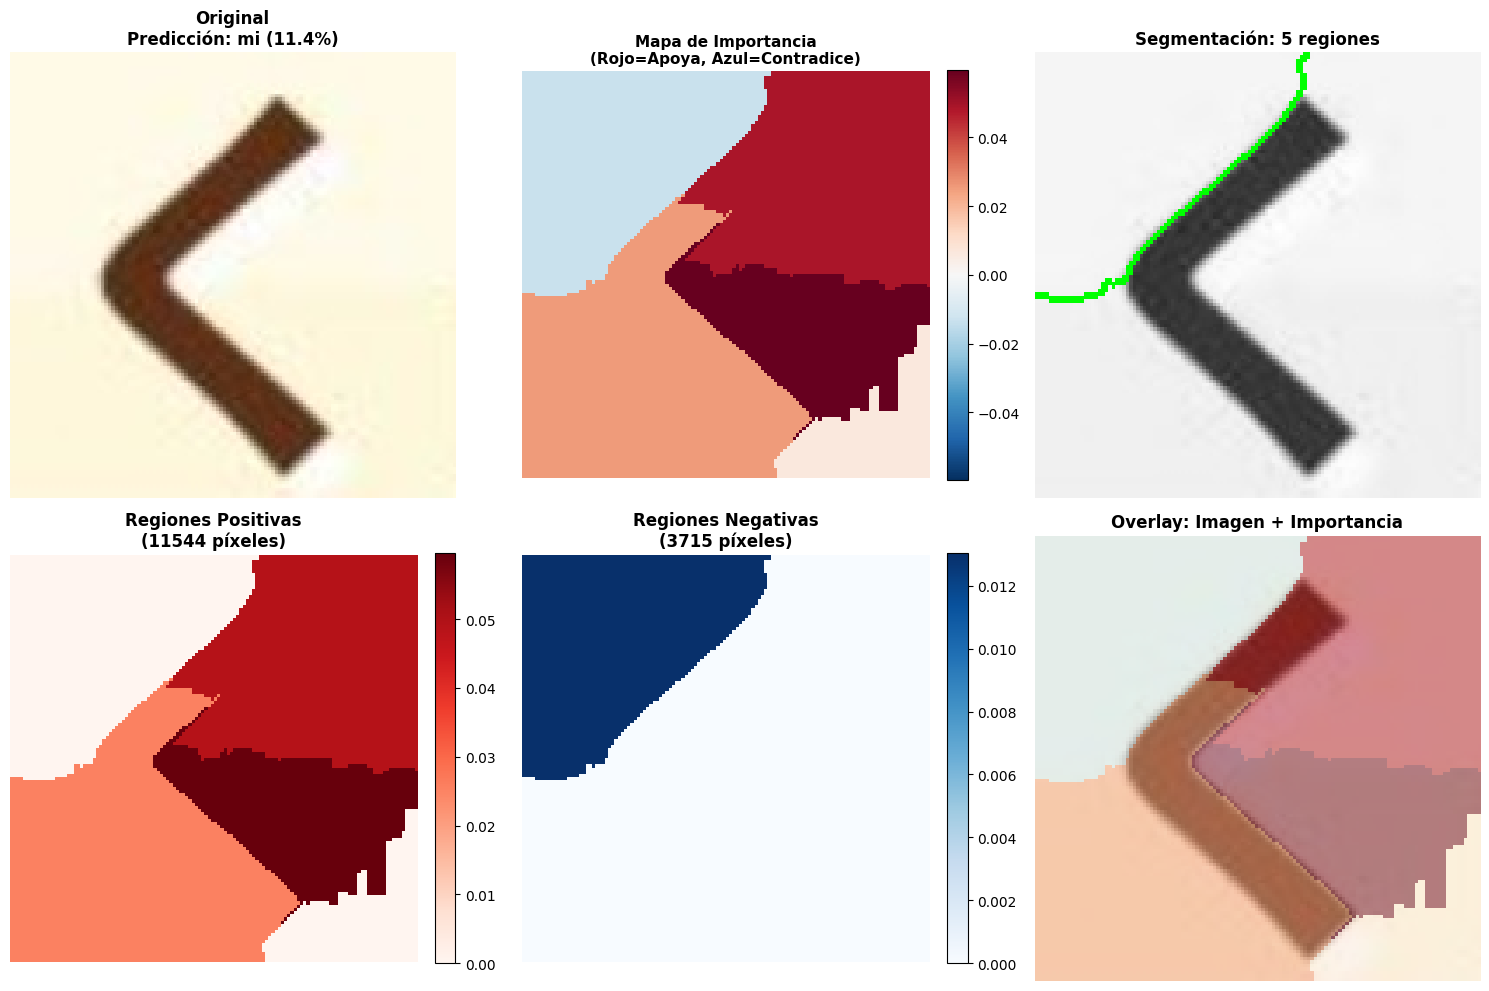


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
2        +0.0596       100.0%      APOYA fuertemente
0        +0.0488        82.0%      APOYA fuertemente
3        +0.0254        42.6%      APOYA fuertemente
1        -0.0130        21.9%      CONTRADICE
4        +0.0061        10.2%      APOYA fuertemente

RESUMEN ESTADÍSTICO
Total de regiones: 5
Regiones positivas: 3 (60.0%)
Regiones negativas: 1 (20.0%)
Regiones neutrales: 1 (20.0%)

Peso positivo máximo: +0.0596
Peso positivo promedio: +0.0446
Peso negativo mínimo: -0.0130
Peso negativo promedio: -0.0130



IMAGEN 6/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: ta_test.jpg
Predicción del modelo: ki
Confianza: 10.12%

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0274, 0.0274]
Total de regiones: 10



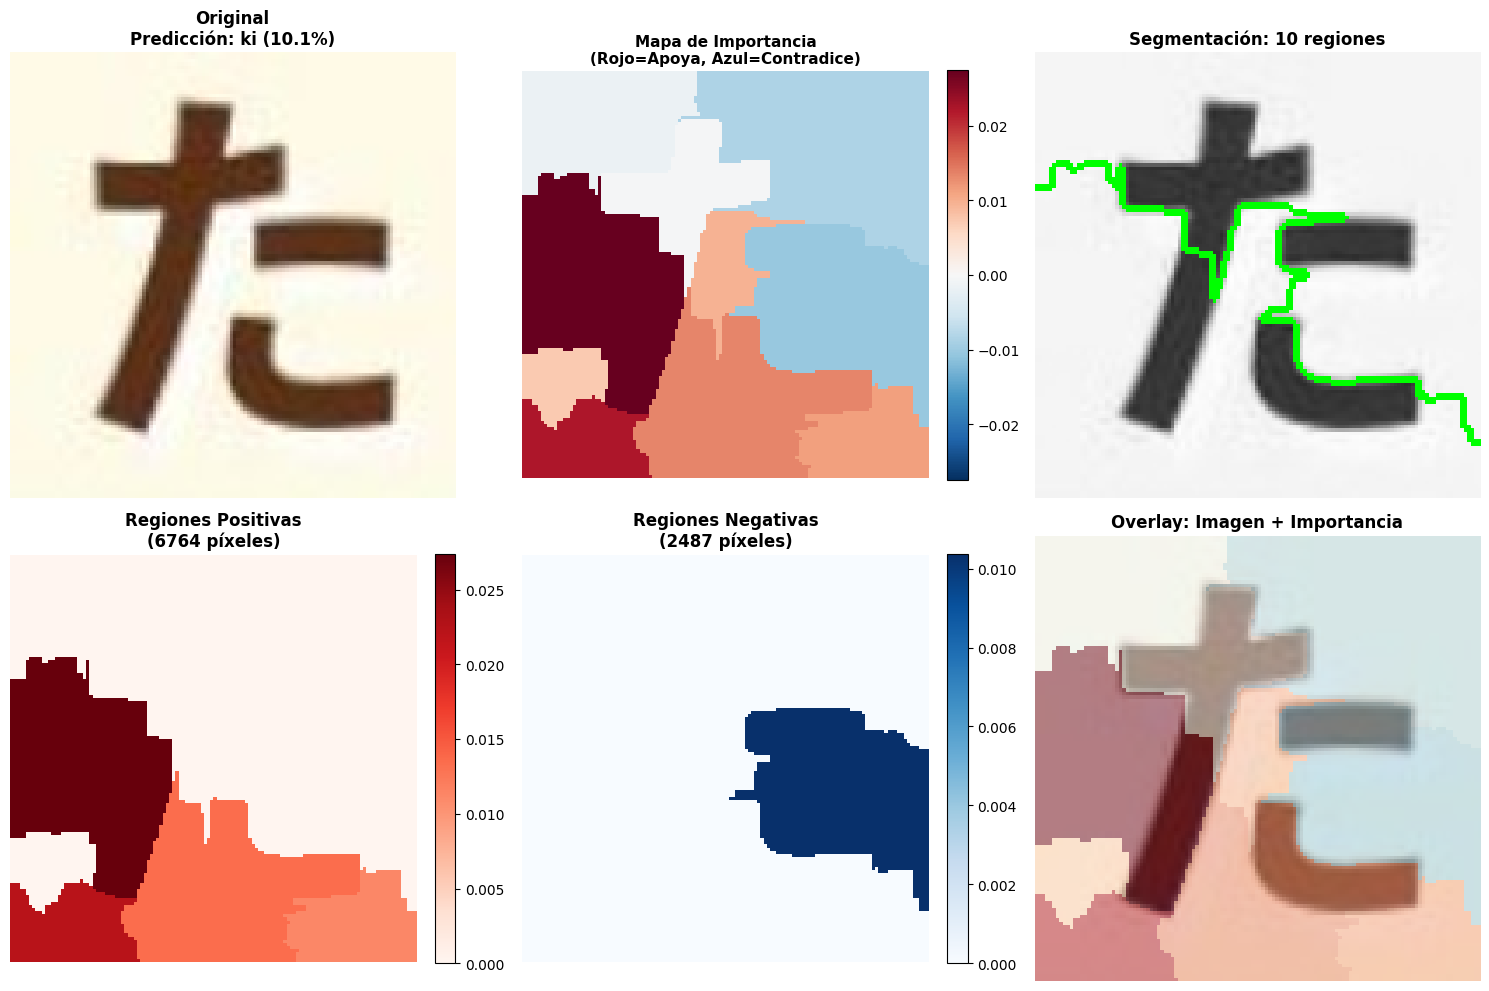


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
4        +0.0274       100.0%      APOYA fuertemente
7        +0.0223        81.1%      APOYA fuertemente
8        +0.0134        49.0%      APOYA fuertemente
9        +0.0112        40.8%      APOYA fuertemente
5        -0.0104        37.9%      CONTRADICE
3        +0.0095        34.6%      APOYA fuertemente
1        -0.0084        30.5%      CONTRADICE
6        +0.0073        26.5%      APOYA fuertemente
0        -0.0016         5.7%      Neutral
2        -0.0004         1.5%      Neutral

RESUMEN ESTADÍSTICO
Total de regiones: 10
Regiones positivas: 4 (40.0%)
Regiones negativas: 1 (10.0%)
Regiones neutrales: 5 (50.0%)

Peso positivo máximo: +0.0274
Peso positivo promedio: +0.0186
Peso negativo mínimo: -0.0104
Peso negativo promedio: -0.0104



IMAGEN 7/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: ni_test

  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.1705, 0.1705]
Total de regiones: 13



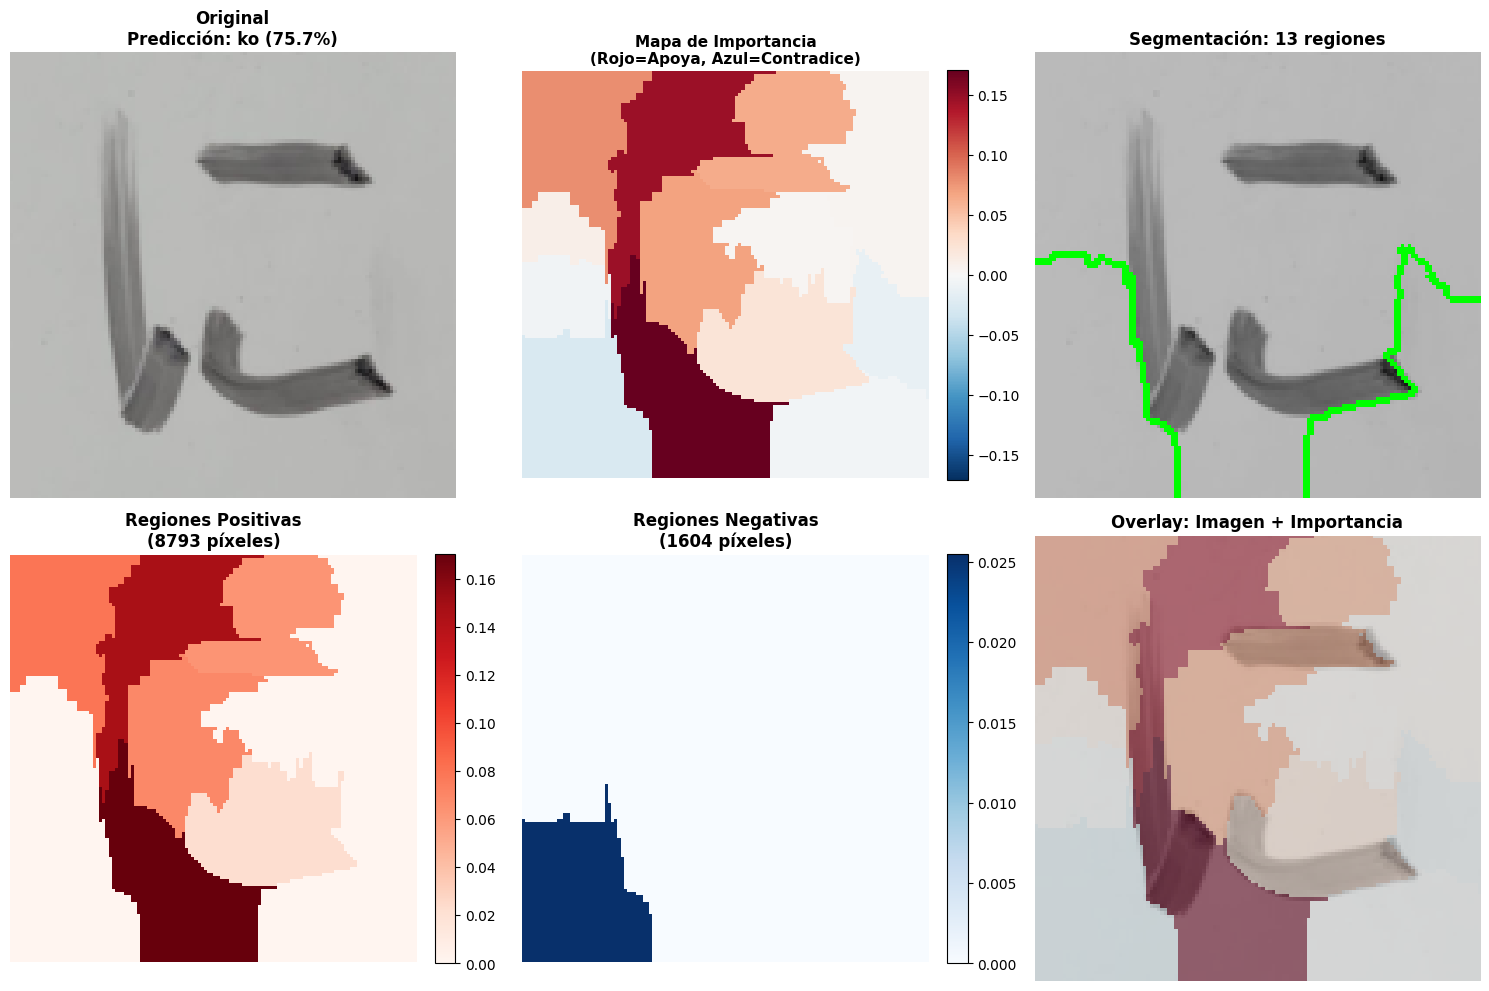


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
12       +0.1705       100.0%      APOYA fuertemente
1        +0.1463        85.8%      APOYA fuertemente
0        +0.0789        46.3%      APOYA fuertemente
6        +0.0690        40.5%      APOYA fuertemente
2        +0.0632        37.1%      APOYA fuertemente
10       -0.0255        15.0%      CONTRADICE
8        +0.0221        13.0%      APOYA fuertemente
9        -0.0125         7.4%      Neutral
4        +0.0106         6.2%      Apoya ligeramente
7        -0.0054         3.2%      Neutral

RESUMEN ESTADÍSTICO
Total de regiones: 13
Regiones positivas: 6 (46.2%)
Regiones negativas: 1 (7.7%)
Regiones neutrales: 6 (46.2%)

Peso positivo máximo: +0.1705
Peso positivo promedio: +0.0917
Peso negativo mínimo: -0.0255
Peso negativo promedio: -0.0255



IMAGEN 8/8

EXPLICABLE AI - TRANSFER LEARNING
Analizando imagen: r

  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0100, 0.0100]
Total de regiones: 11



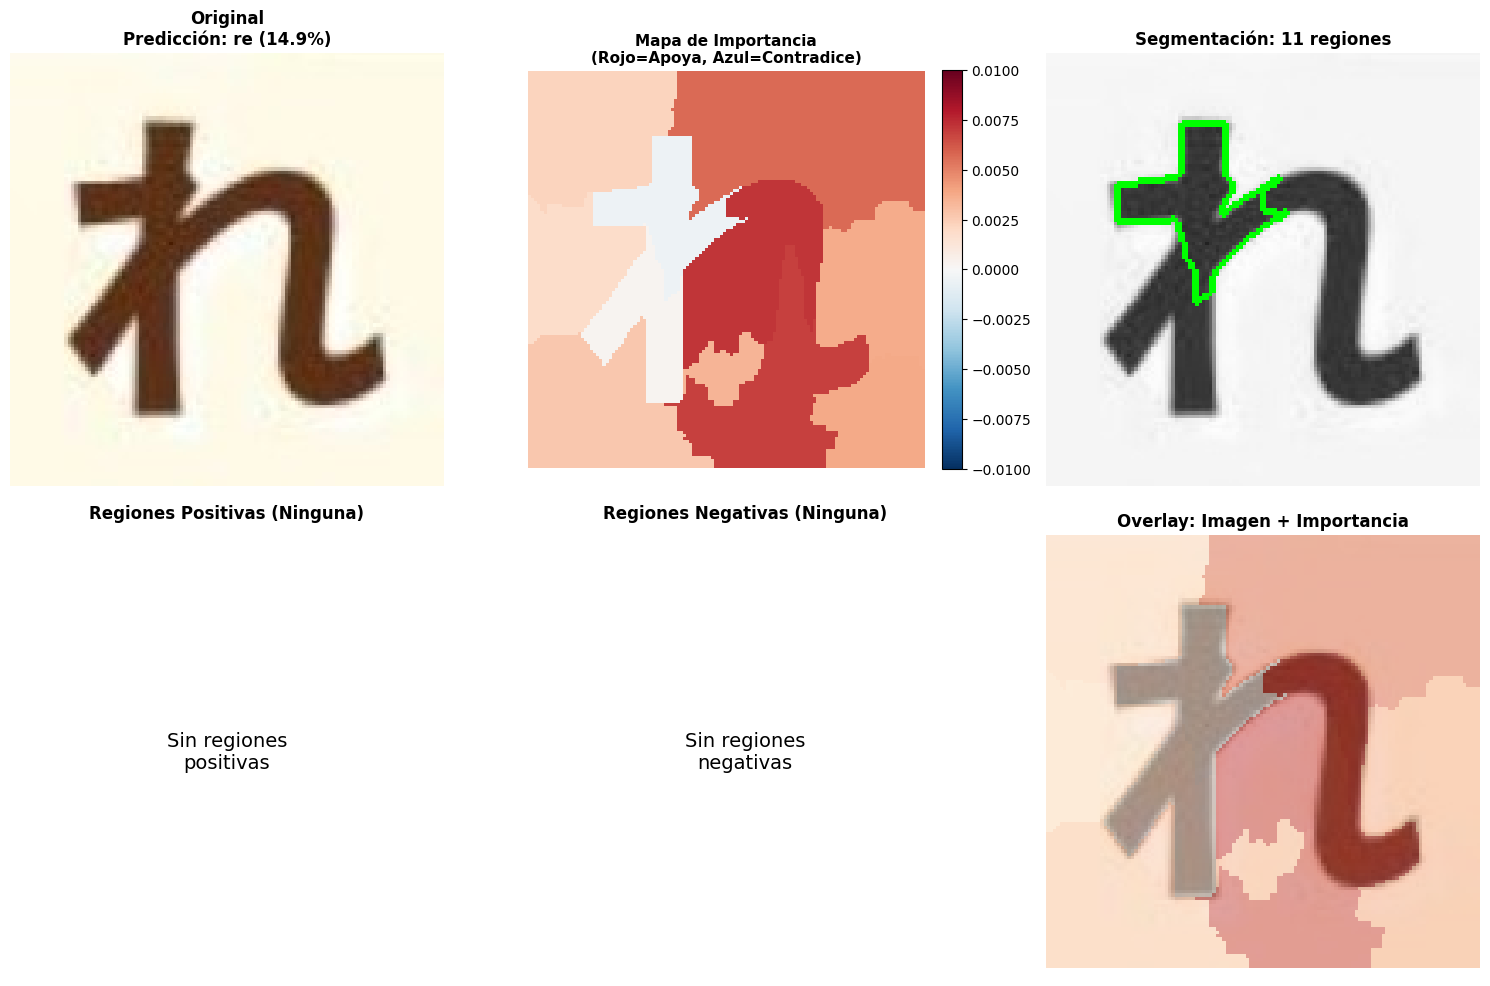


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
6        +0.0071       100.0%      APOYA fuertemente
9        +0.0068        95.4%      APOYA fuertemente
1        +0.0057        79.9%      APOYA fuertemente
10       +0.0038        53.5%      APOYA fuertemente
3        +0.0037        51.5%      APOYA fuertemente
7        +0.0034        47.6%      APOYA fuertemente
8        +0.0027        38.1%      APOYA fuertemente
0        +0.0022        31.1%      APOYA fuertemente
4        +0.0018        25.8%      APOYA fuertemente
2        -0.0005         6.7%      Neutral

RESUMEN ESTADÍSTICO
Total de regiones: 11
Regiones positivas: 0 (0.0%)
Regiones negativas: 0 (0.0%)
Regiones neutrales: 11 (100.0%)




In [39]:
# Buscar más imágenes en el repositorio
extra_imgs_path = '/content/Proyecto-DeepLearning/extra_imgs'

if os.path.exists(extra_imgs_path):
    image_files = [f for f in os.listdir(extra_imgs_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Imágenes encontradas en {extra_imgs_path}:")
    for img_file in image_files:
        print(f"  - {img_file}")

    # Explicar cada imagen
    for idx, img_file in enumerate(image_files, 1):
        img_path = os.path.join(extra_imgs_path, img_file)
        print(f"\n{'='*60}")
        print(f"IMAGEN {idx}/{len(image_files)}")
        print(f"{'='*60}")

        explain_hiragana_with_lime_transfer(
            image_path=img_path,
            model=model,
            class_labels=class_labels,
            idx=idx
        )

        print("\n")
else:
    print(f"No se encontró el directorio: {extra_imgs_path}")